In [108]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. 导入必要库和相关函数定义

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from omegaconf import OmegaConf
import hydra
from lightning import Fabric
from torch_geometric.utils import to_dense_batch

from funcmol.utils.constants import PADDING_INDEX
from funcmol.utils.utils_nf import create_neural_field, load_neural_field
from funcmol.utils.gnf_converter import GNFConverter
from funcmol.dataset.dataset_field import create_field_loaders

In [ ]:
def create_output_dir():
    """Create output directory if it doesn't exist."""
    output_dir = "reconstruction_results"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

def visualize_molecule_comparison(orig_coords, orig_types, recon_coords, recon_types=None, matched_coords=None, save_path=None):
    """Visualize original and reconstructed molecules side by side with atom type colors."""
    # 原子类型颜色映射
    atom_colors = {
        0: 'black',   # C
        1: 'gray',    # H
        2: 'red',     # O
        3: 'blue',    # N
        4: 'green',   # F
    }
    
    fig = plt.figure(figsize=(15, 7))
    
    # Original molecule
    ax1 = fig.add_subplot(131, projection='3d')
    orig_coords_np = orig_coords.detach().cpu().numpy()
    orig_types_np = orig_types.detach().cpu().numpy()
    
    # 为每个原子类型绘制不同颜色
    for atom_type in range(5):  # 0-4: C, H, O, N, F
        mask = (orig_types_np == atom_type)
        if mask.sum() > 0:
            ax1.scatter(orig_coords_np[mask, 0], orig_coords_np[mask, 1], orig_coords_np[mask, 2], 
                       c=atom_colors[atom_type], marker='o', s=100, label=f'Original {["C", "H", "O", "N", "F"][atom_type]}')
    ax1.set_title("Original Molecule")
    ax1.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))  # 固定在右上角
    
    # Reconstructed molecule
    ax2 = fig.add_subplot(132, projection='3d')
    recon_coords_np = recon_coords.detach().cpu().numpy()
    
    if recon_types is not None:
        recon_types_np = recon_types.detach().cpu().numpy()
        # 为每个原子类型绘制不同颜色
        for atom_type in range(5):
            mask = (recon_types_np == atom_type)
            if mask.sum() > 0:
                ax2.scatter(recon_coords_np[mask, 0], recon_coords_np[mask, 1], recon_coords_np[mask, 2], 
                           c=atom_colors[atom_type], marker='o', s=100, label=f'Reconstructed {["C", "H", "O", "N", "F"][atom_type]}')
    else:
        ax2.scatter(recon_coords_np[:, 0], recon_coords_np[:, 1], recon_coords_np[:, 2], 
                   c='r', marker='o', s=100, label='Reconstructed')
    ax2.set_title("Reconstructed Molecule")
    ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))  # 固定在右上角
    
    # Matched reconstruction
    if matched_coords is not None:
        ax3 = fig.add_subplot(133, projection='3d')
        matched_coords_np = matched_coords.detach().cpu().numpy()
        
        # 绘制原始分子（半透明）
        for atom_type in range(5):
            mask = (orig_types_np == atom_type)
            if mask.sum() > 0:
                ax3.scatter(orig_coords_np[mask, 0], orig_coords_np[mask, 1], orig_coords_np[mask, 2], 
                           c=atom_colors[atom_type], marker='o', s=100, alpha=0.5, label=f'Original {["C", "H", "O", "N", "F"][atom_type]}')
        
        # 绘制重建分子（半透明）
        if recon_types is not None:
            for atom_type in range(5):
                mask = (recon_types_np == atom_type)
                if mask.sum() > 0:
                    ax3.scatter(matched_coords_np[mask, 0], matched_coords_np[mask, 1], matched_coords_np[mask, 2], 
                               c=atom_colors[atom_type], marker='s', s=100, alpha=0.5, label=f'Matched {["C", "H", "O", "N", "F"][atom_type]}')
        else:
            ax3.scatter(matched_coords_np[:, 0], matched_coords_np[:, 1], matched_coords_np[:, 2], 
                       c='r', marker='s', s=100, alpha=0.5, label='Matched')
        ax3.set_title("Matched Comparison")
        ax3.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))  # 固定在右上角
    
    for ax in fig.axes:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.grid(True)
        # Set consistent axis limits (adjusted for [-1, 1] range)
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()
    
    return fig

def visualize_iteration_step(coords, coords_types, z_dict, iteration, save_path):
    """Visualize a single iteration step of the reconstruction process with atom type colors."""
    # 原子类型颜色映射
    atom_colors = {
        0: 'black',   # C
        1: 'gray',    # H
        2: 'red',     # O
        3: 'blue',    # N
        4: 'green',   # F
    }
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot original coordinates with colors
    coords_np = coords.detach().cpu().numpy()
    coords_types_np = coords_types.detach().cpu().numpy()
    
    for atom_type in range(5):
        mask = (coords_types_np == atom_type)
        if mask.sum() > 0:
            ax.scatter(coords_np[mask, 0], coords_np[mask, 1], coords_np[mask, 2], 
                      c=atom_colors[atom_type], marker='o', s=100, 
                      label=f'Original {["C", "H", "O", "N", "F"][atom_type]}', alpha=0.7)
    
    # Plot current reconstruction points for each atom type
    for atom_type, z in z_dict.items():
        if z is not None and len(z) > 0:
            z_np = z.detach().cpu().numpy()
            ax.scatter(z_np[:, 0], z_np[:, 1], z_np[:, 2], 
                      c=atom_colors[atom_type], marker='.', s=10, label=f'Current {["C", "H", "O", "N", "F"][atom_type]}', alpha=0.3)
    
    ax.set_title(f"Iteration {iteration}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.grid(True)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))  # 固定在右上角
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()

def compute_rmsd(coords1, coords2):
    """Calculate symmetric RMSD between two sets of coordinates"""
    # 先计算距离（不是平方距离）
    dist1 = torch.sqrt(torch.sum((coords1.unsqueeze(1) - coords2.unsqueeze(0))**2, dim=2) + 1e-8)
    dist2 = torch.sqrt(torch.sum((coords2.unsqueeze(1) - coords1.unsqueeze(0))**2, dim=2) + 1e-8)
    
    # 对距离取min
    min_dist1 = torch.min(dist1, dim=1)[0]  # 对于coords1中的每个点，找到最近的coords2中的点
    min_dist2 = torch.min(dist2, dim=1)[0]  # 对于coords2中的每个点，找到最近的coords1中的点
    
    # 直接平均，不需要再开方
    rmsd = (torch.mean(min_dist1) + torch.mean(min_dist2)) / 2
    
    return rmsd

def reconstruction_loss(coords1, points):
    """Calculate reconstruction loss between original coordinates and sampled points"""
    # Calculate pairwise distances between all points
    dist1 = torch.sum((coords1.unsqueeze(1) - points.unsqueeze(0))**2, dim=2)
    
    eps = 1e-8
    
    # For each original atom, find the closest sampled point
    min_dist_to_samples = torch.min(dist1 + eps, dim=1)[0]
    
    # For each sampled point, find the closest original atom
    min_dist_to_atoms = torch.min(dist1 + eps, dim=0)[0]
    
    # Combine both directions
    coverage_loss = torch.mean(min_dist_to_samples)  # 确保每个原子都有近邻采样点
    clustering_loss = torch.mean(min_dist_to_atoms)  # 确保采样点集中在原子位置附近
    
    # 总损失是两个方向的加权和
    total_loss = coverage_loss + 0.1 * clustering_loss  # 可以调整权重
    
    return torch.sqrt(total_loss)

def plot_loss_curve(iterations, loss_values, save_path=None):
    """Plot loss values over iterations."""
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, loss_values, '-b', label='Reconstruction Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Reconstruction Loss vs. Iterations')
    plt.grid(True)
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def compute_kl_divergences(coords1, coords2, temperature=0.1):
    """
    Calculate bidirectional KL divergences between two sets of coordinates.
    Uses soft assignments based on distances to compute probability distributions.
    
    Args:
        coords1, coords2: Coordinate tensors of shape (N1, 3) and (N2, 3)
        temperature: Temperature parameter for softmax (controls distribution sharpness)
    
    Returns:
        kl_1to2: KL(P(coords1)||P(coords2)) - treating coords2 as reference
        kl_2to1: KL(P(coords2)||P(coords1)) - treating coords1 as reference
    """
    # Calculate pairwise distances
    dist_matrix = torch.sum((coords1.unsqueeze(1) - coords2.unsqueeze(0))**2, dim=2)
    
    # Convert distances to probabilities using softmax
    p1_given_2 = torch.softmax(-dist_matrix / temperature, dim=0)  # P(coords1|coords2)
    p2_given_1 = torch.softmax(-dist_matrix / temperature, dim=1)  # P(coords2|coords1)
    
    eps = 1e-8  # 防止取对数时出现零值
    
    # Compute KL divergences
    kl_1to2 = torch.mean(torch.sum(p1_given_2 * torch.log(p1_given_2 / (1.0/coords2.shape[0] + eps) + eps), dim=0))
    kl_2to1 = torch.mean(torch.sum(p2_given_1 * torch.log(p2_given_1 / (1.0/coords1.shape[0] + eps) + eps), dim=1))
    
    return kl_1to2, kl_2to1

def create_reconstruction_animation(coords, atom_types, converter, output_dir, save_interval=100):
    """Create and save animation of the reconstruction process for all atom types simultaneously."""
    device = coords.device
    n_atom_types = 5  # C, H, O, N, F
    
    # 为每个原子类型初始化采样点
    z_dict = {}
    for atom_type in range(n_atom_types):
        z_dict[atom_type] = torch.rand(converter.n_query_points, 3, device=device) * 2 - 1
    
    # Create GNF function using original coordinates
    def gnf_func(points):
        # 获取多通道梯度场 [1, n_points, n_atom_types, 3]
        vector_field = converter.mol2gnf(coords, atom_types, points)
        return vector_field[0]  # [n_points, n_atom_types, 3]
    
    # Lists to store frame paths and metrics
    frame_paths = []
    loss_values = []
    rmsd_values = []
    kl_1to2_values = []  # KL(P(orig)||P(recon))
    kl_2to1_values = []  # KL(P(recon)||P(orig))
    iterations = []
    
    # Gradient descent(ascent) with visualization
    for i in range(converter.n_iter):
        # 为每个原子类型计算梯度并更新
        for atom_type in range(n_atom_types):
            if z_dict[atom_type] is not None:
                # 计算当前原子类型的梯度
                gradients = gnf_func(z_dict[atom_type])  # [n_points, n_atom_types, 3]
                type_gradients = gradients[:, atom_type, :]  # [n_points, 3]
                
                # 更新采样点位置
                z_dict[atom_type] = z_dict[atom_type] + converter.step_size * type_gradients
        
        # Save visualization and compute metrics at intervals
        if i % save_interval == 0 or i == converter.n_iter - 1:
            frame_path = os.path.join(output_dir, f"frame_{i:04d}.png")
            visualize_iteration_step(coords, atom_types, z_dict, i, frame_path)
            frame_paths.append(frame_path)
            
            # 合并所有原子类型的点用于计算指标
            all_points = []
            for atom_type in range(n_atom_types):
                if z_dict[atom_type] is not None:
                    all_points.append(z_dict[atom_type])
            
            if all_points:
                combined_points = torch.cat(all_points, dim=0)
                
                # Compute and store optimization loss
                loss = reconstruction_loss(coords, combined_points)
                loss_values.append(loss.item())
                
                # Compute and store current metrics
                current_points = converter._merge_points(combined_points.detach().cpu().numpy())
                
                # 检查是否有有效的重建点
                if len(current_points) > 0:
                    current_points = torch.from_numpy(current_points).to(device)
                    
                    # Compute RMSD
                    rmsd = compute_rmsd(coords, current_points)
                    rmsd_values.append(rmsd.item())
                    
                    # Compute KL divergences
                    kl_1to2, kl_2to1 = compute_kl_divergences(coords, current_points)
                    kl_1to2_values.append(kl_1to2.item())
                    kl_2to1_values.append(kl_2to1.item())
                else:
                    # 如果没有重建点，使用原始采样点计算指标
                    print(f"Warning: No clusters found at iteration {i}, using raw points for metrics")
                    rmsd = compute_rmsd(coords, combined_points)
                    rmsd_values.append(rmsd.item())
                    
                    kl_1to2, kl_2to1 = compute_kl_divergences(coords, combined_points)
                    kl_1to2_values.append(kl_1to2.item())
                    kl_2to1_values.append(kl_2to1.item())
                
                iterations.append(i)
    
    # Create GIF from frames
    gif_path = os.path.join(output_dir, "reconstruction_process.gif")
    with imageio.get_writer(gif_path, mode='I', duration=0.2) as writer:
        for frame_path in frame_paths:
            image = imageio.imread(frame_path)
            writer.append_data(image)
    
    # Clean up individual frame files
    for frame_path in frame_paths:
        os.remove(frame_path)
    
    # Plot and save metrics curves
    plot_metrics_curves(iterations, loss_values, rmsd_values, kl_1to2_values, kl_2to1_values,
                     save_path=os.path.join(output_dir, "metrics_curves.png"))
    
    # 合并所有原子类型的结果
    all_coords = []
    all_types = []
    
    for atom_type in range(n_atom_types):
        if z_dict[atom_type] is not None:
            # 聚类/合并当前原子类型的点
            z_np = z_dict[atom_type].detach().cpu().numpy()
            merged_points = converter._merge_points(z_np)
            
            if len(merged_points) > 0:
                all_coords.append(torch.from_numpy(merged_points).to(device))
                all_types.append(torch.full((len(merged_points),), atom_type, dtype=torch.long, device=device))
    
    # 合并所有原子类型的结果
    if all_coords:
        reconstructed_coords = torch.cat(all_coords, dim=0)
        reconstructed_types = torch.cat(all_types, dim=0)
    else:
        # 如果没有重建点，使用原始采样点作为备选
        print("Warning: No clusters found, using raw points as reconstruction")
        all_raw_coords = []
        all_raw_types = []
        for atom_type in range(n_atom_types):
            if z_dict[atom_type] is not None:
                all_raw_coords.append(z_dict[atom_type])
                all_raw_types.append(torch.full((z_dict[atom_type].size(0),), atom_type, dtype=torch.long, device=device))
        
        if all_raw_coords:
            reconstructed_coords = torch.cat(all_raw_coords, dim=0)
            reconstructed_types = torch.cat(all_raw_types, dim=0)
        else:
            reconstructed_coords = torch.empty(0, 3, device=device)
            reconstructed_types = torch.empty(0, dtype=torch.long, device=device)
    
    # Return final points and convergence data
    return (reconstructed_coords, reconstructed_types), {
        'iterations': iterations, 
        'loss_values': loss_values,
        'rmsd_values': rmsd_values,
        'kl_1to2_values': kl_1to2_values,
        'kl_2to1_values': kl_2to1_values
    }

def plot_metrics_curves(iterations, loss_values, rmsd_values, kl_1to2_values, kl_2to1_values, save_path=None):
    """Plot all metrics (loss, RMSD, and KL divergences) over iterations."""
    plt.figure(figsize=(12, 8))
    
    # Create a figure with shared x-axis
    plt.subplot(211)
    line1, = plt.plot(iterations, loss_values, '-b', label='Reconstruction Loss')
    line2, = plt.plot(iterations, rmsd_values, '-r', label='RMSD')
    plt.grid(True)
    plt.legend()
    plt.ylabel('Loss / RMSD')
    plt.title('Reconstruction Metrics vs. Iterations')
    
    # Create twin axis for KL divergences
    plt.subplot(212)
    line3, = plt.plot(iterations, kl_1to2_values, '-g', label='KL(P(orig)||P(recon))')
    line4, = plt.plot(iterations, kl_2to1_values, '-m', label='KL(P(recon)||P(orig))')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('KL Divergence')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def visualize_gradient_field(coords: torch.Tensor, converter: GNFConverter, save_path: str, 
                               n_grid=30, padding=1.0, arrow_scale=0.3):
    """可视化3D空间中的梯度场
    
    Args:
        coords: 原子坐标 (N, 3)
        converter: GNF转换器
        save_path: 保存路径
        n_grid: 每个维度的网格点数
        padding: 超出原子坐标范围的额外空间
        arrow_scale: 箭头缩放因子
    """
    # 计算采样范围（基于原子坐标自动确定）
    min_vals = coords.min(dim=0)[0] - padding
    max_vals = coords.max(dim=0)[0] + padding
    
    # 创建3D采样网格
    x = torch.linspace(min_vals[0], max_vals[0], n_grid)
    y = torch.linspace(min_vals[1], max_vals[1], n_grid)
    z = torch.linspace(min_vals[2], max_vals[2], n_grid)
    y *= 0
    z *= 0
    X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')
    
    # 生成查询点 (n_grid^3, 3)
    query_points = torch.stack([X.flatten(), Y.flatten(), Z.flatten()], dim=1).to(coords.device)
    
    # 计算梯度
    with torch.no_grad():
        gradients = converter.mol2gnf(coords, query_points)
    
    # 转换为numpy数组
    coords_np = coords.cpu().numpy()
    query_points_np = query_points.cpu().numpy()
    gradients_np = gradients.cpu().numpy()
    
    # 计算梯度范数
    gradient_norms = np.linalg.norm(gradients_np, axis=1)
    norm = plt.Normalize(vmin=gradient_norms.min(), vmax=gradient_norms.max())
    
    # 创建图形
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制原子位置
    ax.scatter(coords_np[:, 0], coords_np[:, 1], coords_np[:, 2], 
              c='red', s=100, label='Target Atoms', depthshade=True)
    
    # 为了可视化清晰，可以每隔k个点采样一个箭头
    # stride = max(1, len(query_points_np) )  # 限制箭头数量
    stride = 1
    
    # 绘制3D梯度场箭头
    for i in range(0, len(query_points_np), stride):
        point = query_points_np[i]
        gradient = gradients_np[i]
        norm_value = gradient_norms[i]
        
        if norm_value < 1e-6:  # 忽略零梯度
            continue
            
        # 归一化梯度方向
        direction = gradient / (np.linalg.norm(gradient) + 1e-8)
        length = arrow_scale * np.log1p(norm_value)  # 非线性缩放
        
        ax.quiver(point[0], point[1], point[2],
                 direction[0], direction[1], direction[2],
                 length=4 * length, 
                 color=plt.cm.viridis(norm(norm_value)),
                 arrow_length_ratio=0.5,  # 箭头头部比例
                 linewidth=0.9,
                 alpha=0.8) 
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Gradient Field')
    
    # 添加颜色条
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    fig.colorbar(sm, ax=ax, label='Gradient Magnitude', shrink=0.7)
    
    # 调整视角
    ax.view_init(elev=30, azim=45)  # 设置默认视角
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

## 2. 设置参数，初始化converter

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory
output_dir = create_output_dir()

# Parameters
n_atoms = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

# 原子类型映射：0=C, 1=H, 2=O, 3=N, 4=F
# 你可以根据需要修改这个列表来设置不同的原子类型
atom_type_list = [0, 0, 1, 1, 1, 1, 2, 3, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]  # 示例：C-C-H-H-H-H-O-N-C-C-H-H-H-H-C-C-H-H-H-H

# Create atom types tensor
atom_types = torch.tensor(atom_type_list, dtype=torch.long, device=device)

# Generate random molecule
coords = torch.rand(n_atoms, 3, device=device) * 2 - 1

# Initialize converter with optimized parameters
converter = GNFConverter(
        sigma=1,  # Controls the spread of the Gaussian field
        n_query_points=500,  # More points for better coverage
        n_iter=2000,  # More iterations for convergence
        step_size=0.002,  # Conservative step size
        eps = 0.1,  # threshold for merging
        min_samples = 5,
        sigma_ratios = {
            'C': 0.9,
            'H': 1.3,
            'O': 1.1,
            'N': 1.0,
            'F': 1.2
        },
        version = 2,
        temperature = 0.008,
        device=device
    )

## 4. 运行重建过程

In [112]:
# 在运行重建过程的cell中
print("Starting molecule reconstruction test...")
print(f"Device: {device}")
print(f"Number of atoms in original molecule: {n_atoms}")

# Create reconstruction animation and get final coordinates
print("\nCreating reconstruction animation...")
(reconstructed_coords, reconstructed_types), convergence_data = create_reconstruction_animation(coords, atom_types, converter, output_dir)

Starting molecule reconstruction test...
Device: cuda
Number of atoms in original molecule: 20

Creating reconstruction animation...
[DBSCAN] Total points: 5000, Clusters found: 279, Noise points: 2457
[DBSCAN] Total points: 5000, Clusters found: 179, Noise points: 1743
[DBSCAN] Total points: 5000, Clusters found: 104, Noise points: 1449
[DBSCAN] Total points: 5000, Clusters found: 85, Noise points: 1066
[DBSCAN] Total points: 5000, Clusters found: 26, Noise points: 766
[DBSCAN] Total points: 5000, Clusters found: 14, Noise points: 717
[DBSCAN] Total points: 5000, Clusters found: 15, Noise points: 764
[DBSCAN] Total points: 5000, Clusters found: 18, Noise points: 819
[DBSCAN] Total points: 5000, Clusters found: 21, Noise points: 853
[DBSCAN] Total points: 5000, Clusters found: 21, Noise points: 885
[DBSCAN] Total points: 5000, Clusters found: 22, Noise points: 906
[DBSCAN] Total points: 5000, Clusters found: 22, Noise points: 931
[DBSCAN] Total points: 5000, Clusters found: 22, Noise p

## 5. 评估指标和可视化效果


Reconstruction Results:
Final Loss: 0.0511
Final RMSD: 0.0309
Final KL(P(orig)||P(recon)): 2.5898
Final KL(P(recon)||P(orig)): 2.4522
Number of reconstructed atoms: 22

Saving final visualization...


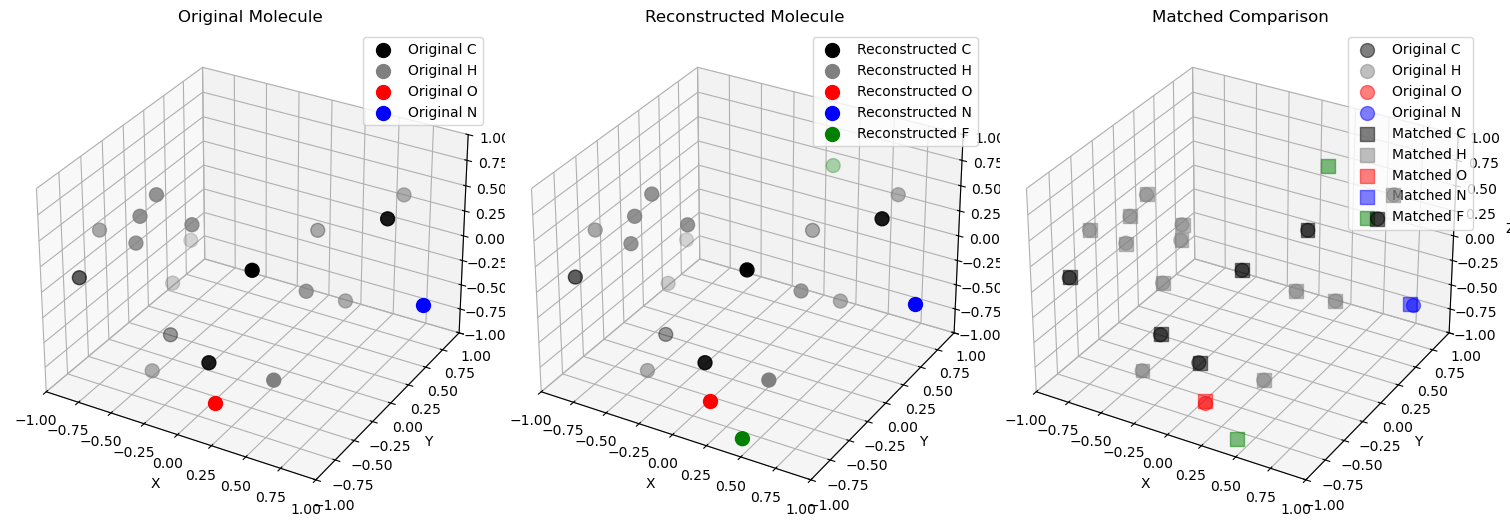

In [113]:
# First ensure coords and reconstructed are torch tensors
if isinstance(reconstructed_coords, tuple):
    reconstructed_coords = reconstructed_coords[0]

# Calculate final metrics
final_loss = reconstruction_loss(coords, reconstructed_coords)
final_rmsd = compute_rmsd(coords, reconstructed_coords)
final_kl_1to2, final_kl_2to1 = compute_kl_divergences(coords, reconstructed_coords)

# Print results
print("\nReconstruction Results:")
print(f"Final Loss: {final_loss:.4f}")
print(f"Final RMSD: {final_rmsd:.4f}")
print(f"Final KL(P(orig)||P(recon)): {final_kl_1to2:.4f}")
print(f"Final KL(P(recon)||P(orig)): {final_kl_2to1:.4f}")
print(f"Number of reconstructed atoms: {len(reconstructed_coords)}")

# Save final visualization
print("\nSaving final visualization...")
visualize_molecule_comparison(
    coords, 
    atom_types,
    reconstructed_coords, 
    reconstructed_types,
    reconstructed_coords,
    save_path=os.path.join(output_dir, "final_comparison.png")
)

## 7. 探究导致RMSD异常的原因

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def visualize_with_outliers(coords1, coords2, outliers_info):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 原始坐标
    ax.scatter(coords1[:,0], coords1[:,1], coords1[:,2], c='blue', label='Ground Truth')
    ax.scatter(coords2[:,0], coords2[:,1], coords2[:,2], c='red', label='Reconstructed')

    # 高误差点
    ax.scatter(outliers_info["outlier_coords1"][:,0], outliers_info["outlier_coords1"][:,1], outliers_info["outlier_coords1"][:,2], 
               c='cyan', s=60, marker='o', label='Outliers in GT')
    ax.scatter(outliers_info["outlier_coords2"][:,0], outliers_info["outlier_coords2"][:,1], outliers_info["outlier_coords2"][:,2], 
               c='orange', s=60, marker='^', label='Outliers in Reconstructed')

    ax.legend()
    plt.show()


